This step involves applying various data mining techniques to the transformed data to discover hidden patterns, trends, relationships, and insights. 

In [1]:
import utils
import pandas as pd 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Load data
df: pd.DataFrame = utils.load_preprocessed_data()

# split data into train and test
X_train, X_test, y_train, y_test = utils.split_data(df)

In [12]:
# Model selection process with pipeline of models
# Create a pipeline
pipeline_lr=Pipeline([('lr_classifier',LogisticRegression(random_state=0))])

pipeline_svc=Pipeline([('svc_classifier',SVC(random_state=0))])

pipeline_knn=Pipeline([('knn_classifier',KNeighborsClassifier())])

pipeline_dt=Pipeline([ ('dt_classifier',DecisionTreeClassifier(random_state=0))])

pipeline_rf=Pipeline([('rf_classifier',RandomForestClassifier(random_state=0))])

pipeline_xgb=Pipeline([('xgb_classifier',XGBClassifier(random_state=0))])

pipeline_mpl=Pipeline([('mpl_classifier',MLPClassifier(random_state=0))])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_svc, pipeline_knn, pipeline_dt, pipeline_rf, pipeline_xgb, pipeline_mpl]

# Dictionary of pipelines and classifier types 
pipe_dict = {0: 'LR',
            1: 'SVC',
            2: 'KNN', 
            3: "DT",
            4: "RF",
            5: "XGB",
            6: "MLP"
            }


# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

#cross validation on accuracy 
cv_results_accuracy = []
for i, model in enumerate(pipelines):
    """
    The cross_val_score() function will be used to perform the evaluation,
    taking the training dataset and cross-validation configuration and returning
    a list of scores calculated for each fold.
    """
    cv_score = cross_val_score(model, X_train,y_train, cv=10 )
    cv_results_accuracy.append(cv_score)
    print("%s: %.3f (%.3f) " % (pipe_dict[i], cv_score.mean(), cv_score.std()))

LR: 0.892353 (0.022) 
SVC: 0.911176 (0.018) 
KNN: 0.904706 (0.015) 
DT: 0.919412 (0.023) 
RF: 0.945294 (0.012) 
XGB: 0.951765 (0.008) 
MLP: 0.927647 (0.016) 


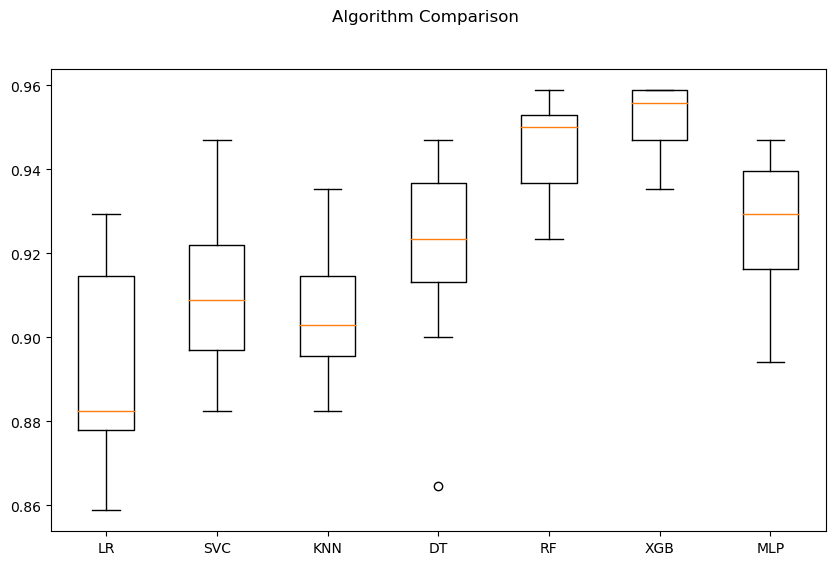

In [4]:
# boxplot algorithm comparison
utils.algorithm_comparison(cv_results_accuracy, pipe_dict)

- Gradient Boosted Tree is the best performer among the executed models array. 
- Let's build XGBoost model with grid search cv hyperparameter optimization routine.


In [5]:
# Model selection process with grid search hyperparameter tuning

#Building a dictionary with a list of optional values that will be tested for each parameter of xgboost
parameters = { 
    'xgb_classifier__max_depth': [3, 5, 7],
    'xgb_classifier__min_child_weight':[1, 3, 5],
    'xgb_classifier__subsample':[0.5, 0.7],
    'xgb_classifier__colsample_bytree':[0.5, 0.7],
    'xgb_classifier__n_estimators':[100, 200, 500],
    'xgb_classifier__learning_rate': [0.01, 0.05, 0.1]
}

#Fitting the training set to find parameters with best accuracy
grid_search = GridSearchCV(pipeline_xgb, parameters, n_jobs=-1, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

#Printing the best parameters
print("Best parameters: ", grid_search.best_params_)

#Printing the best accuracy
print("Best score: ", grid_search.best_score_)

Best parameters:  {'xgb_classifier__colsample_bytree': 0.5, 'xgb_classifier__learning_rate': 0.05, 'xgb_classifier__max_depth': 5, 'xgb_classifier__min_child_weight': 1, 'xgb_classifier__n_estimators': 500, 'xgb_classifier__subsample': 0.7}
Best score:  0.9558823529411764


In [17]:
xgb_classifier = XGBClassifier(**grid_search.best_params_)
xgb_classifier.fit(X_train, y_train)

# save model
pd.to_pickle(xgb_classifier, '../artifacts/xgb_classifier.pkl')